In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import pyreadr
import mercantile
from shapely.geometry import shape
import networkx as nx
import seaborn as sn
import pickle

# Generation of timeseries of networks for daily mobility flows

## Import data and preprocessing

In [2]:
###############
# Import data #
###############

root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results' 


compute_again = True

if compute_again == True:
    # Reads in the timeseries of between tiles movement data
    root1 = root_data+'/GBR_BETWEEN_TILES_DAILY_TRIP_NUMBERS.csv'
    df = pd.read_csv(root1)

    # Converting the quadkeys to strings
    df['start_quadkey'] = df['start_quadkey'].astype(str)
    df['end_quadkey'] = df['end_quadkey'].astype(str)
    # adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
    df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
    df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

    # Replace nan by 0
    df = df.fillna(0)

    #################################
    # Filtering out rows outside UK #
    #################################

    # Load filtered quadkeys
    
    root_filtering = root_results + '/Filtering'
    root2 = root_filtering+'/base_quadkeys_filtered.pickle'
    with open(root2, 'rb') as handle:
        quadkeys_timeseries_UK = pickle.load(handle)

    quadkeys_timeseries_UK = set(quadkeys_timeseries_UK)

    df_filtered = df.copy()

    for i in range(df.shape[0]):

        start_included =  df.iloc[i]['start_quadkey'] in quadkeys_timeseries_UK 
        end_included = df.iloc[i]['end_quadkey'] in quadkeys_timeseries_UK 
        included = start_included + end_included

        if included != 2:
            df_filtered = df_filtered.drop([i])

    print('Number of deleted rows:', df.shape[0] - df_filtered.shape[0])

    df = df_filtered.reset_index(drop=True)
    df.to_csv(root_results+'/Timeseries/FilteredDataFrame.csv',index=False) 

else:
    df = pd.read_csv(root_results+'/Timeseries/FilteredDataFrame.csv')
    # Converting the quadkeys to strings
    df['start_quadkey'] = df['start_quadkey'].astype(str)
    df['end_quadkey'] = df['end_quadkey'].astype(str)
    # adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
    df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
    df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

    # Replace nan by 0
    df = df.fillna(0)
    
###########################
# Get dates of timeseries #
###########################

# Get start and end dates
start_date = df.columns.values[2][:10]
end_date = df.columns.values[-1][:10]

# Generate DatetimeIndex
days = pd.date_range(start=start_date, end=end_date).date
n_days = len(days)
days_dm = np.asarray([str(days[i])[5:] for i in range(n_days)])
days_week = np.asarray(pd.date_range(start=start_date, end=end_date).weekofyear, dtype='int')
weeks = np.arange(days_week.min(),days_week.max())

# Store lockdown-date
lockdown_date = pd.to_datetime('20200324', format='%Y%m%d', errors='ignore')
lockdown_date_number = np.argwhere(days == lockdown_date).flatten()[0]

# Store second lockdown-date
second_lockdown_date = pd.to_datetime('20201105', format='%Y%m%d', errors='ignore')
second_lockdown_date_number = np.argwhere(days == second_lockdown_date).flatten()[0]

Number of deleted rows: 428


In [7]:
root_figure = '/Users/ignaciosacristanbarba/Documents/M4R/Figures/'

## Generation of daily DiGraphs

Generate network for each day by summing over all hours per day. 

In [8]:
compute_graphs_again = True
if compute_graphs_again == True:    
    # Get the first two quadkey columns
    df_key = df.iloc[:,:2]
    
    M = df.shape[1]-3
    networks = []

    for i in range(1,M,3):

        ##################
        # Get daily data #
        ##################

        df_mov = df.iloc[:,i+1:i+4]
        df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
        df_sum = pd.concat([df_key,df_sum],axis=1)

        ####################
        # Generate DiGraph #
        ####################

        N = len(df_sum)
        G = nx.DiGraph()
        # for each row, add nodes and weighted edge
        for j in range(0,N):
            start = df_sum['start_quadkey'][j]
            end = df_sum['end_quadkey'][j]
            weight = df_sum['movement'][j]
            G.add_node(start)
            G.add_node(end)
            if weight > 0.0:
                G.add_weighted_edges_from([(start, end, weight)] )

        # Append DiGraph to list of networks
        networks.append(G)
        
        
    root4 = root_results + '/Timeseries'+'/timeseries_daily_digraphs.pkl'
    with open(root4, 'wb') as handle:
            pickle.dump(networks, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        
else:
    root4 = root_results+'/Timeseries'+'/timeseries_daily_digraphs.pkl'
    with open(root4, 'rb') as handle:
        networks = pickle.load(handle)

# add polygons as node attributes
G = networks[0]
quadkeys = list(G.nodes)
n_nodes = len(quadkeys)

polys = []

#Iterates over the quadkeys to extract the tiles
for quadkey in quadkeys:
    
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))

geom = [shape(i) for i in polys]
geom_dict = {quadkeys[i] : list(geom[i].centroid.bounds[:2]) for i in range(0,n_nodes)}

n_networks = len(networks)

for i in range(0,n_days):
    G = networks[i]
    nx.set_node_attributes(G,geom_dict,'geom')

# Store node keys
node_numbers = {i : list(networks[0].nodes())[i] for i in range(n_nodes)}
# Gemo dicy for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

    


IndexError: list index out of range

## Generation of weekly DiGraphs

In [5]:
networks_adjacency = [nx.adjacency_matrix(networks[i]) for i in range(n_networks)]
networks_week = []

for i in weeks:
    days_of_week = np.asarray(np.argwhere(days_week==i).flatten(),dtype = 'int')
    adjacency_week = networks_adjacency[days_of_week[0]:days_of_week[-1]+1]
    A = adjacency_week[0]
    for j in range(1,len(adjacency_week)):
        A+= adjacency_week[j]
    A /= len(adjacency_week)
    
    G = nx.DiGraph(A)
    networks_week.append(G)

n_weeks = len(networks_week)

for i in range(0,n_weeks):
    G = networks[i]
    nx.set_node_attributes(G,geom_dict_numbers,'geom')
    

# Descriptive statistics for daily DiGraphs

In [ ]:
networks_adjacency = [nx.adjacency_matrix(networks[i]) for i in range(n_networks)]
compute_stats_again = True

if compute_stats_again == True:
    n_total = []
    n_total_inter = []
    n_total_intra = []
    for A in networks_adjacency:
        intra = np.diag(np.diag(A.toarray()))
        B = A - intra
        n_total.append(np.sum(A))
        n_total_inter.append(np.sum(B))
        n_total_intra.append(np.sum(intra))

    results = pd.DataFrame({'day':days, 'n_total': n_total, 
                            'n_total_inter' : n_total_inter, 
                            'n_total_intra':n_total_intra})
    
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    #with open(root5, 'wb') as handle:
        #results.to_csv(root5)
            
else:
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    with open(root5, 'rb') as handle:
        results = pd.read_csv(root5)


# Plot
fig, ax = plt.subplots(1,figsize =(15,10))
ax.plot(results['n_total'],label='n_total',color = 'C1')
#ax.axhline(y = n_total_lscc, ls = '--', label = 'base',color='C1')
ax.plot(results['n_total_inter'],label='n_total_inter',color='C2')
#ax.axhline(y = n_total_inter_lscc, ls = '--', label = 'base inter',color='C2')
ax.plot(results['n_total_intra'],label='n_total_intra',color='C3')
#ax.axhline(y = n_total_intra_lscc, ls = '--', label = 'base intra',color='C3')
ax.axvline(x = lockdown_date_number, label = 'First lockdown date', color = 'red')

ax.axvline(x = second_lockdown_date_number, label = 'Second lockdown date', color = 'purple')

ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.legend()
plt.show()
fig.savefig(root_figure+'/Timeseries_fulldata'+'/full_network_components.eps', dpi=fig.dpi,bbox_inches='tight')

## Number of WCCs and size of LWCC

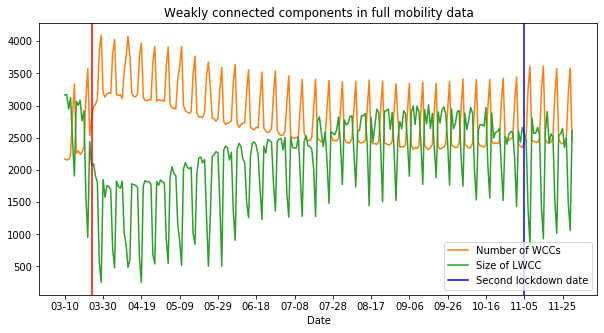

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [46]:
compute_wcc_and_size = True
if compute_wcc_and_size == True:
    n_nodes = len(networks[0].nodes)

    # Compute number of WCCs and size of LWCC
    n_wcc = []
    s_lwcc = []

    for G in networks:
        n_wcc.append(nx.algorithms.components.number_weakly_connected_components(G))
        s_lwcc.append(len(max(nx.algorithms.components.weakly_connected_components(G), key=len)))

    # Store results in dataframe
    results['n_wcc'] = n_wcc
    results['s_lwcc'] = s_lwcc
    
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    with open(root5, 'wb') as handle:
        results.to_csv(root5)
    
else:
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    with open(root5, 'rb') as handle:
        results = pd.read_csv(root5)
    

# Plot
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(results['n_wcc'],label='Number of WCCs', color = 'C1')
ax.plot(results['s_lwcc'],label='Size of LWCC', color = 'C2')
ax.axvline(x = lockdown_date_number, color = 'red')
ax.axvline(x = second_lockdown_date_number, label = 'Second lockdown date', color = 'blue')
ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks],xlabel='Date',
      title='Weakly connected components in full mobility data')
ax.legend(loc=4)
plt.show()
fig.savefig(root_figure+'/Timeseries_fulldata'+'/n_components.eps', dpi=fig.dpi,bbox_inches='tight')

This result is very strange, as it does not coincide with the findings in "Human Mobility in Response to COVID-19 in France, Italy and UK", where the size of the LWCC is always bigger than the number of WCCs. However, the results above look exactly like the results for France.

## Number of SCCs and size of LSCC

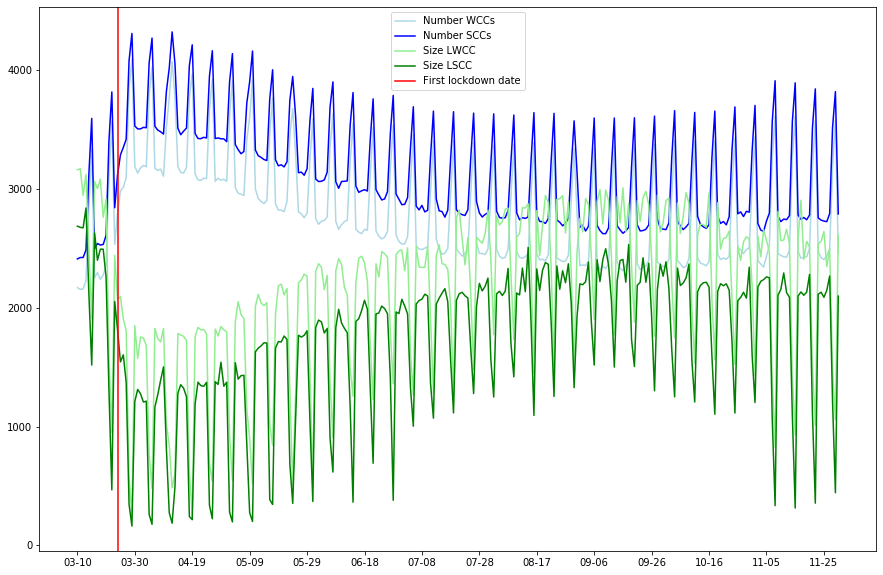

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [48]:
compute_scc_and_size = True
if compute_scc_and_size == True:
    # Compute number of SCCs and size of LSCC

    n_scc = []
    s_lscc = []

    for G in networks:
        n_scc.append(nx.algorithms.components.number_strongly_connected_components(G))
        s_lscc.append(len(max(nx.algorithms.components.strongly_connected_components(G), key=len)))

    # Store results
    results['n_scc'] = n_scc
    results['s_lscc'] = s_lscc
    
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    with open(root5, 'wb') as handle:
        results.to_csv(root5)
    
else:
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    with open(root5, 'rb') as handle:
        results = pd.read_csv(root5)

# Plot
fig, ax = plt.subplots(1,figsize =(15,10))
ax.plot(results['n_wcc'],label='Number WCCs', color = 'lightblue')
ax.plot(results['n_scc'],label='Number SCCs', color = 'blue')
ax.plot(results['s_lwcc'],label='Size LWCC', color = 'lightgreen')
ax.plot(results['s_lscc'],label='Size LSCC', color = 'green')
ax.axvline(x = lockdown_date_number, label = 'First lockdown date', color = 'red')

ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.legend()
plt.show()
fig.savefig(root_figure+'/Timeseries_fulldata'+'/s_components.eps', dpi=fig.dpi,bbox_inches='tight')

## Global efficiency and gini index based on reciprocal weight


Note that networkx ignores edge weights and is not applicable to directed networks! 
https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.global_efficiency.html#networkx.algorithms.efficiency_measures.global_efficiency



In [49]:
G = networks[0]
d = dict(nx.algorithms.shortest_paths.weighted.all_pairs_dijkstra_path_length(G, weight = 'weight'))

So I develop a function to compute global efficiency as presented in literature, using Dijkstra's algorithm. The reciprocal of the edge weight is used for computing the shortest path lengths.


First, compute the reciprocal weights as distances between nodes.

In [50]:
# Compute reciprocal weights
for i in range(0,n_days):
    G = networks[i]
    weights = nx.get_edge_attributes(G,'weight')
    reciprocal = {}

    for key,value in weights.items():
        reciprocal[key] = 1/value

    nx.set_edge_attributes(G, reciprocal, 'reciprocal')

Compute gini index of numpy array, following: https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy

In [51]:
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

Note that scipy does not support Dijkstra for directed graphs.

In [52]:
def global_efficiency_and_gini(G, weight = 'reciprocal'):
    '''
    input: weighted networkx DiGraph
    output: global efficiency and gini index for local efficiencies
    '''
    
    n_nodes = len(networks[0].nodes)
    E_glob = 0
    E_loc = []
    
    # Get all path lengths with Dijkstra
    all_paths_length = dict(nx.algorithms.shortest_paths.weighted.all_pairs_dijkstra_path_length(G,weight=weight))
    
    # Sum over 
    for start, paths in all_paths_length.items():
        # Initialise local efficiency
        e = 0
        for end, path_length in paths.items():
            if path_length>0:
                # Add to global efficiency
                E_glob += 1/path_length
                # Add to local efficiency
                e += 1/path_length
        e /= n_nodes-1
        E_loc.append(e)
        
    E_glob /= n_nodes*(n_nodes - 1)
    
    # Compute gini index
    E_loc = np.asarray(E_loc)
    g = gini(E_loc)
    
    
    return E_glob, g

Computing the global efficiencies and gini indices for the time series of networks takes about 30 minutes. 

In [19]:
# Compute global efficiency
compute_gini_efficiency_again = True
if compute_gini_efficiency_again == True:
    E_glob = []
    ginis = []

    for G in networks:
        e, g = global_efficiency_and_gini(G, weight = 'reciprocal')

        E_glob.append(e)
        ginis.append(g)

    results['E_glob_reciprocal'] = E_glob
    results['gini_reciprocal'] = ginis
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    with open(root5, 'wb') as handle:
        results.to_csv(root5)
    
else:
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    with open(root5, 'rb') as handle:
        results = pd.read_csv(root5)
    

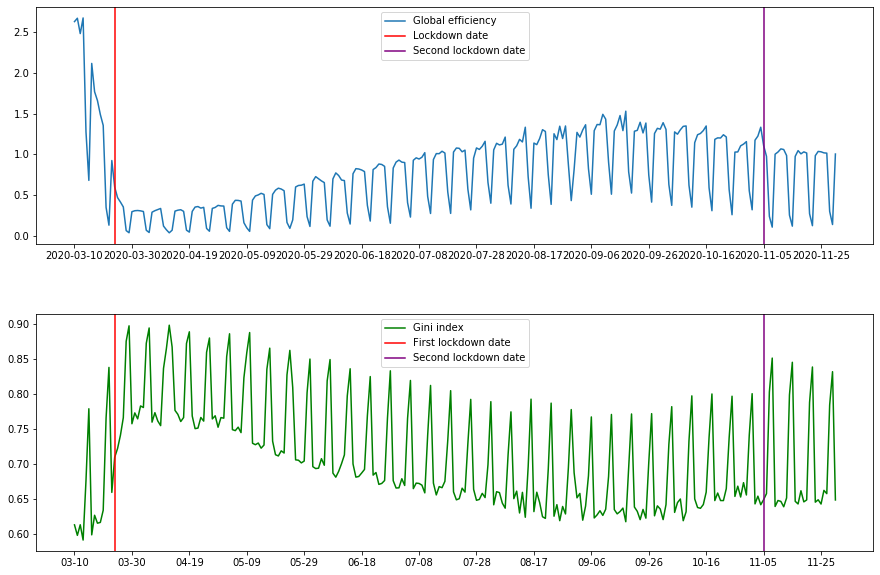

In [39]:
# Plot global efficiency and gini index
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(results['E_glob_reciprocal'],label='Global efficiency')
ax1.axvline(x = lockdown_date_number, label = 'Lockdown date', color = 'red')
ax1.axvline(x = second_lockdown_date_number, label = 'Second lockdown date', color = 'purple')

ticks = range(0,n_days,20)
ax1.set(xticks = ticks, xticklabels = days[ticks])
ax1.legend()

ax2.plot(results['gini_reciprocal'],label='Gini index', color = 'green')
ax2.axvline(x = lockdown_date_number, label = 'First lockdown date', color = 'red')
ax2.axvline(x = second_lockdown_date_number, label = 'Second lockdown date', color = 'purple')

ax2.set(xticks = ticks, xticklabels = days_dm[ticks])
ax2.legend()


plt.show()
fig.savefig(root_figure+'/Timeseries_fulldata'+'/gini_efficiency.eps', dpi=fig.dpi,bbox_inches='tight')

### Store results

In [22]:
# Save to csv file
results.to_csv(root_results+'/Timeseries/timeseries_networks_results',index=False) 

In [23]:
# Read results from file
results = pd.read_csv(root_results+'/timeseries_networks_results')

# Descriptive statistics for weekly DiGraphs

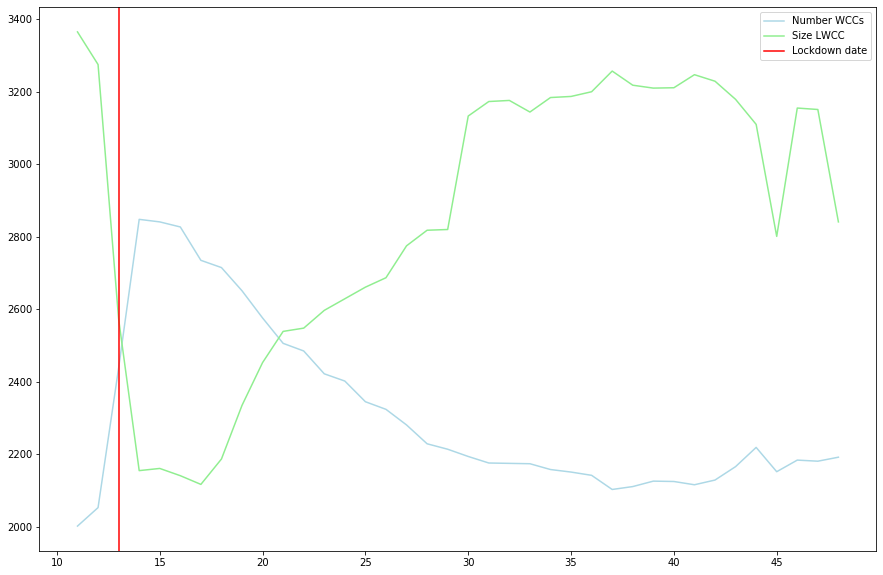

In [24]:
# Compute number of WCCs and size of LWCC

n_wcc = []
s_lwcc = []

for G in networks_week:
    n_wcc.append(nx.algorithms.components.number_weakly_connected_components(G))
    s_lwcc.append(len(max(nx.algorithms.components.weakly_connected_components(G), key=len)))
    
# Store results in dataframe
results_week = pd.DataFrame({'week':weeks,'n_wcc':n_wcc, 's_lwcc':s_lwcc})

# Plot
fig, ax = plt.subplots(1,figsize =(15,10))
ax.plot(results_week['week'],results_week['n_wcc'],label='Number WCCs', color = 'lightblue')
ax.plot(results_week['week'],results_week['s_lwcc'],label='Size LWCC', color = 'lightgreen')
ax.axvline(x = lockdown_date.weekofyear, label = 'Lockdown date', color = 'red')
ax.legend()
plt.show()

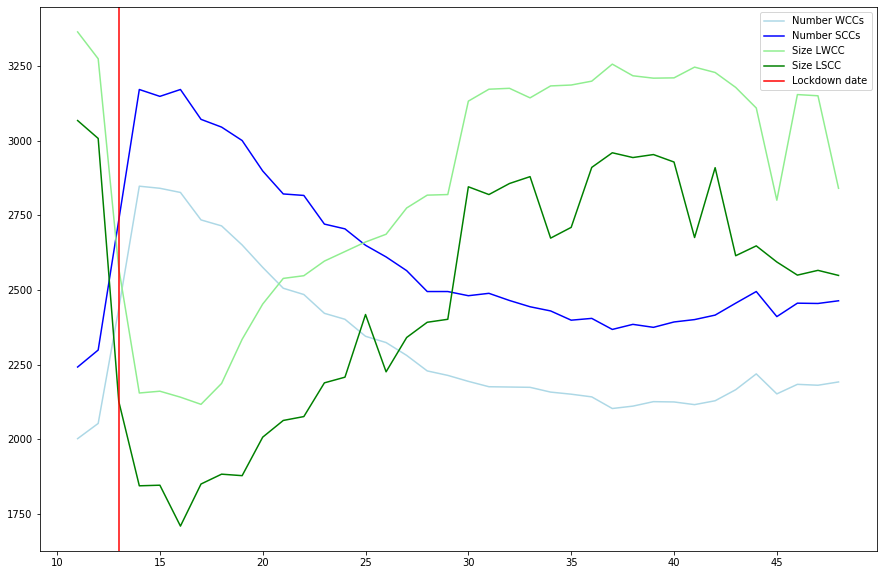

In [26]:
# Compute number of SCCs and size of LSCC

n_scc = []
s_lscc = []

for G in networks_week:
    n_scc.append(nx.algorithms.components.number_strongly_connected_components(G))
    s_lscc.append(len(max(nx.algorithms.components.strongly_connected_components(G), key=len)))

# Store results
results_week['n_scc'] = n_scc
results_week['s_lscc'] = s_lscc

# Plot
fig, ax = plt.subplots(1,figsize =(15,10))
ax.plot(results_week['week'],results_week['n_wcc'],label='Number WCCs', color = 'lightblue')
ax.plot(results_week['week'],results_week['n_scc'],label='Number SCCs', color = 'blue')
ax.plot(results_week['week'],results_week['s_lwcc'],label='Size LWCC', color = 'lightgreen')
ax.plot(results_week['week'],results_week['s_lscc'],label='Size LSCC', color = 'green')
ax.axvline(x = lockdown_date.weekofyear, label = 'Lockdown date', color = 'red')
ax.legend()
plt.show()

# TRY WITH JANUARY DATA

# Generation of timeseries of networks for daily mobility flows

## Import data and preprocessing

In [10]:
###############
# Import data #
###############



root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results' 


compute_again = True

if compute_again == True:
    # Reads in the timeseries of between tiles movement data
    root1 = root_data+'/GBR_BETWEEN_TILES_DAILY_TRIP_NUMBERS.csv'
    df = pd.read_csv(root1)

    # Converting the quadkeys to strings
    df['start_quadkey'] = df['start_quadkey'].astype(str)
    df['end_quadkey'] = df['end_quadkey'].astype(str)
    # adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
    df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
    df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

    # Replace nan by 0
    df = df.fillna(0)

    #################################
    # Filtering out rows outside UK #
    #################################

    # Load filtered quadkeys
    
    root_filtering = root_results + '/Filtering'
    root2 = root_filtering+'/base_quadkeys_filtered.pickle'
    with open(root2, 'rb') as handle:
        quadkeys_timeseries_UK = pickle.load(handle)

    quadkeys_timeseries_UK = set(quadkeys_timeseries_UK)

    df_filtered = df.copy()

    for i in range(df.shape[0]):

        start_included =  df.iloc[i]['start_quadkey'] in quadkeys_timeseries_UK 
        end_included = df.iloc[i]['end_quadkey'] in quadkeys_timeseries_UK 
        included = start_included + end_included

        if included != 2:
            df_filtered = df_filtered.drop([i])

    print('Number of deleted rows:', df.shape[0] - df_filtered.shape[0])

    #df = df_filtered.reset_index(drop=True)
    #df.to_csv(root_results+'/Timeseries/FilteredDataFrame.csv',index=False) 

else:
    df = pd.read_csv(root_results+'/Timeseries/FilteredDataFrame.csv')
    # Converting the quadkeys to strings
    df['start_quadkey'] = df['start_quadkey'].astype(str)
    df['end_quadkey'] = df['end_quadkey'].astype(str)
    # adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
    df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
    df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

    # Replace nan by 0
    df = df.fillna(0)
    
###########################
# Get dates of timeseries #
###########################

# Get start and end dates
start_date = df.columns.values[2][:10]
end_date = df.columns.values[-1][:10]

# Generate DatetimeIndex
days = pd.date_range(start=start_date, end=end_date).date
n_days = len(days)
days_dm = np.asarray([str(days[i])[5:] for i in range(n_days)])
days_week = np.asarray(pd.date_range(start=start_date, end=end_date).weekofyear, dtype='int')
weeks = np.arange(days_week.min(),days_week.max())

# Store lockdown-date
lockdown_date = pd.to_datetime('20200324', format='%Y%m%d', errors='ignore')
lockdown_date_number = np.argwhere(days == lockdown_date).flatten()[0]

# Store second lockdown-date
second_lockdown_date = pd.to_datetime('20201105', format='%Y%m%d', errors='ignore')
second_lockdown_date_number = np.argwhere(days == second_lockdown_date).flatten()[0]

Number of deleted rows: 428


In [11]:
df

,start_quadkey,end_quadkey,2020-03-10_Tuesday,2020-03-11_Wednesday,2020-03-12_Thursday,2020-03-13_Friday,2020-03-14_Saturday,2020-03-15_Sunday,2020-03-16_Monday,2020-03-17_Tuesday,...,2021-01-22_Friday,2021-01-23_Saturday,2021-01-24_Sunday,2021-01-25_Monday,2021-01-26_Tuesday,2021-01-27_Wednesday,2021-01-28_Thursday,2021-01-29_Friday,2021-01-30_Saturday,2021-01-31_Sunday
0,031131123131,031131123131,15.0,14.0,28.0,23.0,40.0,52.0,16.0,15.0,...,0.0,11.0,0.0,0.0,0.0,0.0,10.0,0.0,20.0,22.0
1,031131130132,031131130132,28.0,26.0,30.0,47.0,54.0,45.0,23.0,23.0,...,22.0,38.0,25.0,29.0,30.0,26.0,32.0,22.0,44.0,31.0
2,031131132023,031131132023,26.0,27.0,15.0,0.0,0.0,0.0,0.0,11.0,...,0.0,0.0,0.0,11.0,17.0,18.0,14.0,0.0,0.0,0.0
3,031131132032,031131132032,58.0,57.0,64.0,63.0,66.0,85.0,63.0,64.0,...,59.0,54.0,66.0,57.0,57.0,62.0,51.0,52.0,59.0,65.0
4,031131132203,031131132203,13.0,13.0,16.0,11.0,44.0,44.0,15.0,14.0,...,15.0,28.0,50.0,14.0,15.0,13.0,19.0,22.0,48.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41565,120202230013,120202230102,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41566,120202230100,120202230100,135.0,147.0,117.0,134.0,185.0,211.0,193.0,192.0,...,176.0,215.0,191.0,187.0,150.0,171.0,159.0,153.0,213.0,206.0
41567,120202230101,120202230101,62.0,72.0,61.0,53.0,73.0,78.0,86.0,103.0,...,58.0,55.0,59.0,68.0,55.0,58.0,57.0,60.0,82.0,78.0
41568,120202230102,120202230102,209.0,219.0,246.0,243.0,242.0,263.0,247.0,237.0,...,213.0,245.0,259.0,245.0,201.0,204.0,198.0,218.0,238.0,250.0


In [12]:
root_figure = '/Users/ignaciosacristanbarba/Documents/M4R/Figures/'

## Generation of daily DiGraphs

Generate network for each day by summing over all hours per day. 

In [20]:
df

,start_quadkey,end_quadkey,2020-03-10_Tuesday,2020-03-11_Wednesday,2020-03-12_Thursday,2020-03-13_Friday,2020-03-14_Saturday,2020-03-15_Sunday,2020-03-16_Monday,2020-03-17_Tuesday,...,2021-01-22_Friday,2021-01-23_Saturday,2021-01-24_Sunday,2021-01-25_Monday,2021-01-26_Tuesday,2021-01-27_Wednesday,2021-01-28_Thursday,2021-01-29_Friday,2021-01-30_Saturday,2021-01-31_Sunday
0,031131123131,031131123131,15.0,14.0,28.0,23.0,40.0,52.0,16.0,15.0,...,0.0,11.0,0.0,0.0,0.0,0.0,10.0,0.0,20.0,22.0
1,031131130132,031131130132,28.0,26.0,30.0,47.0,54.0,45.0,23.0,23.0,...,22.0,38.0,25.0,29.0,30.0,26.0,32.0,22.0,44.0,31.0
2,031131132023,031131132023,26.0,27.0,15.0,0.0,0.0,0.0,0.0,11.0,...,0.0,0.0,0.0,11.0,17.0,18.0,14.0,0.0,0.0,0.0
3,031131132032,031131132032,58.0,57.0,64.0,63.0,66.0,85.0,63.0,64.0,...,59.0,54.0,66.0,57.0,57.0,62.0,51.0,52.0,59.0,65.0
4,031131132203,031131132203,13.0,13.0,16.0,11.0,44.0,44.0,15.0,14.0,...,15.0,28.0,50.0,14.0,15.0,13.0,19.0,22.0,48.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41565,120202230013,120202230102,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41566,120202230100,120202230100,135.0,147.0,117.0,134.0,185.0,211.0,193.0,192.0,...,176.0,215.0,191.0,187.0,150.0,171.0,159.0,153.0,213.0,206.0
41567,120202230101,120202230101,62.0,72.0,61.0,53.0,73.0,78.0,86.0,103.0,...,58.0,55.0,59.0,68.0,55.0,58.0,57.0,60.0,82.0,78.0
41568,120202230102,120202230102,209.0,219.0,246.0,243.0,242.0,263.0,247.0,237.0,...,213.0,245.0,259.0,245.0,201.0,204.0,198.0,218.0,238.0,250.0


In [21]:
compute_graphs_again = True
if compute_graphs_again == True:    
    # Get the first two quadkey columns
    df_key = df.iloc[:,:2]

    M = df.shape[1]-2
    networks = []

    for i in range(1,M,1):

        ##################
        # Get daily data #
        ##################

        df_mov = df.iloc[:,i+1]
        #df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
        
        
        
        ####################
        # Generate DiGraph #
        ####################

        N = len(df_sum)
        G = nx.DiGraph()
        # for each row, add nodes and weighted edge
        for j in range(0,N):
            start = df_key['start_quadkey'][j]
            end = df_key['end_quadkey'][j]
            weight = df_mov[j]
            G.add_node(start)
            G.add_node(end)
            if weight > 0.0:
                G.add_weighted_edges_from([(start, end, weight)] )

        # Append DiGraph to list of networks
        networks.append(G)
        
        
    #root4 = root_results + '/Timeseries'+'/timeseries_daily_digraphs.pkl'
    #with open(root4, 'wb') as handle:
            #pickle.dump(networks, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        
else:
    root4 = root_results+'/Timeseries'+'/timeseries_daily_digraphs.pkl'
    with open(root4, 'rb') as handle:
        networks = pickle.load(handle)

# add polygons as node attributes
G = networks[0]
quadkeys = list(G.nodes)
n_nodes = len(quadkeys)

polys = []

#Iterates over the quadkeys to extract the tiles
for quadkey in quadkeys:
    
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))

geom = [shape(i) for i in polys]
geom_dict = {quadkeys[i] : list(geom[i].centroid.bounds[:2]) for i in range(0,n_nodes)}

n_networks = len(networks)

for i in range(0,n_networks):
    G = networks[i]
    nx.set_node_attributes(G,geom_dict,'geom')

# Store node keys
node_numbers = {i : list(networks[0].nodes())[i] for i in range(n_nodes)}
# Gemo dicy for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

    


All networks have the same nodes and the same node keys.

## Generation of weekly DiGraphs

In [ ]:
networks_adjacency = [nx.adjacency_matrix(networks[i]) for i in range(n_networks)]
networks_week = []

for i in weeks:
    days_of_week = np.asarray(np.argwhere(days_week==i).flatten(),dtype = 'int')
    adjacency_week = networks_adjacency[days_of_week[0]:days_of_week[-1]+1]
    A = adjacency_week[0]
    for j in range(1,len(adjacency_week)):
        A+= adjacency_week[j]
    A /= len(adjacency_week)
    
    G = nx.DiGraph(A)
    networks_week.append(G)

n_weeks = len(networks_week)

for i in range(0,n_weeks):
    G = networks[i]
    nx.set_node_attributes(G,geom_dict_numbers,'geom')
    

# Descriptive statistics for daily DiGraphs

In [ ]:
print(n_networks)

In [ ]:
networks_adjacency = [nx.adjacency_matrix(networks[i]) for i in range(n_networks)]


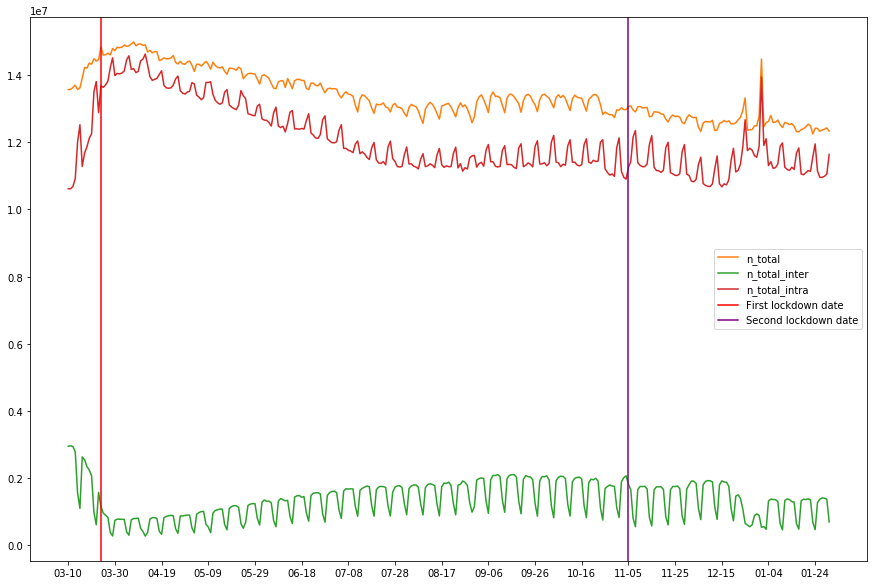

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [23]:

compute_stats_again = True
if compute_stats_again == True:
    n_total = []
    n_total_inter = []
    n_total_intra = []
    for A in networks_adjacency:
        intra = np.diag(np.diag(A.toarray()))
        B = A - intra
        n_total.append(np.sum(A))
        n_total_inter.append(np.sum(B))
        n_total_intra.append(np.sum(intra))

    results = pd.DataFrame({'n_total': n_total, 
                            'n_total_inter' : n_total_inter, 
                            'n_total_intra':n_total_intra})
    
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    #with open(root5, 'wb') as handle:
        #results.to_csv(root5)
            
else:
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    with open(root5, 'rb') as handle:
        results = pd.read_csv(root5)


# Plot
fig, ax = plt.subplots(1,figsize =(15,10))
ax.plot(results['n_total'],label='n_total',color = 'C1')
#ax.axhline(y = n_total_lscc, ls = '--', label = 'base',color='C1')
ax.plot(results['n_total_inter'],label='n_total_inter',color='C2')
#ax.axhline(y = n_total_inter_lscc, ls = '--', label = 'base inter',color='C2')
ax.plot(results['n_total_intra'],label='n_total_intra',color='C3')
#ax.axhline(y = n_total_intra_lscc, ls = '--', label = 'base intra',color='C3')
ax.axvline(x = lockdown_date_number, label = 'First lockdown date', color = 'red')

ax.axvline(x = second_lockdown_date_number, label = 'Second lockdown date', color = 'purple')

ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.legend()
plt.show()
#fig.savefig(root_figure+'/Timeseries_fulldata'+'/full_network_components.eps', dpi=fig.dpi,bbox_inches='tight')

In [25]:
results

,n_total,n_total_inter,n_total_intra,n_wcc,s_lwcc
0,13570495.0,2950491.0,10620004.0,2200,3164
1,13577951.0,2962733.0,10615218.0,2188,3172
2,13629675.0,2942679.0,10686996.0,2188,2948
3,13702354.0,2782161.0,10920193.0,2256,3124
4,13570254.0,1562229.0,12008025.0,2903,2485
...,...,...,...,...,...
322,12330387.0,1372302.0,10958085.0,2723,2363
323,12364101.0,1410170.0,10953931.0,2679,2464
324,12392826.0,1402987.0,10989839.0,2695,2411
325,12428374.0,1374684.0,11053690.0,2741,2171


## Number of WCCs and size of LWCC

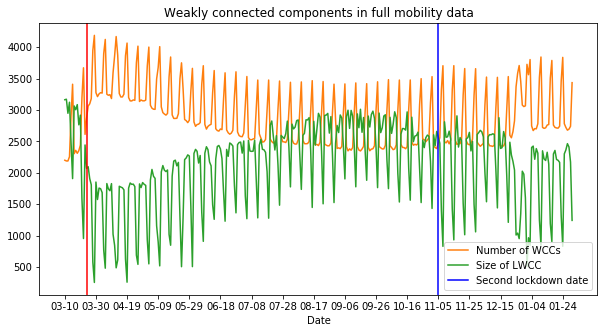

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [24]:
compute_wcc_and_size = True
if compute_wcc_and_size == True:
    n_nodes = len(networks[0].nodes)

    # Compute number of WCCs and size of LWCC
    n_wcc = []
    s_lwcc = []

    for G in networks:
        n_wcc.append(nx.algorithms.components.number_weakly_connected_components(G))
        s_lwcc.append(len(max(nx.algorithms.components.weakly_connected_components(G), key=len)))

    # Store results in dataframe
    results['n_wcc'] = n_wcc
    results['s_lwcc'] = s_lwcc
    
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    with open(root5, 'wb') as handle:
        results.to_csv(root5)
    
else:
    root5 = root_results + '/Timeseries'+'/stats_daily_digraphs.cvs'
    with open(root5, 'rb') as handle:
        results = pd.read_csv(root5)
    

# Plot
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(results['n_wcc'],label='Number of WCCs', color = 'C1')
ax.plot(results['s_lwcc'],label='Size of LWCC', color = 'C2')
ax.axvline(x = lockdown_date_number, color = 'red')
ax.axvline(x = second_lockdown_date_number, label = 'Second lockdown date', color = 'blue')
ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks],xlabel='Date',
      title='Weakly connected components in full mobility data')
ax.legend(loc=4)
plt.show()
fig.savefig(root_figure+'/Timeseries_fulldata'+'/n_components.eps', dpi=fig.dpi,bbox_inches='tight')

This result is very strange, as it does not coincide with the findings in "Human Mobility in Response to COVID-19 in France, Italy and UK", where the size of the LWCC is always bigger than the number of WCCs. However, the results above look exactly like the results for France.